# 时间序列预测

本教程是使用递归神经网络（RNN）进行时间序列预测的简介。它分为两个部分：首先，您将预测单变量时间序列，然后将预测多变量时间序列。

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import pandas as pd


In [0]:
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

##天气数据集
本教程使用[由马克斯·普朗克生物地球化学研究所记录的天气时间序列数据集。

该数据集包含14个不同的特征，例如气温，大气压力和湿度。从2003年开始，每10分钟收集一次。为了提高效率，您将仅使用2009年至2016年之间收集的数据。数据集的这一部分由FrançoisChollet为他的《Python深度学习》准备。

In [4]:
zip_path = keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)

csv_path, _ = os.path.splitext(zip_path)
csv_path

13574144/13568290 [==============================] - 1s 0us/step


'/root/.keras/datasets/jena_climate_2009_2016.csv'

In [27]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


如上所示，每10分钟记录一次观察值。这意味着在一个小时内，您将有6个观测值。同样，一天将包含144（6x24）次观察。

给定一个特定的时间，假设您要预测未来6小时的温度。为了做出此预测，您选择使用5天的观察时间。因此，您将创建一个包含最后720（5x144）个观测值的窗口以训练模型。许多这样的配置都是可能的，这使该数据集成为一个很好的实验对象。

下面的函数返回上述时间窗以供模型训练。该参数history_size是过去信息窗口的大小。这target_size是模型需要学习预测的未来时间。该target_size是需要被预测的标签。

In [0]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size,i)
    data.append(np.reshape(dataset[indices],(history_size,1)))
    labels.append(dataset[i+target_size])
  return np.array(data),np.array(labels)

在以下两个教程中，数据的前300,000行将是训练数据集，而其余将是验证数据集。总计约2100天的训练数据。

In [0]:
TRAIN_SPLIT = 300000

设置种子以确保可重复性。

In [0]:
tf.random.set_seed(13)

##第1部分：预测单变量时间序列
首先，您将仅使用一个特征（温度）训练模型，并在将来使用该模型为该值做出预测。

首先，我们仅从数据集中提取温度。

In [29]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

让我们观察一下这些数据随时间变化的样子。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7c6a80860>],
      dtype=object)

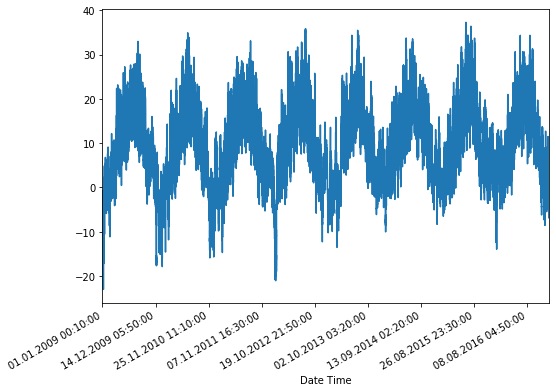

In [10]:
uni_data.plot(subplots=True)

In [0]:
uni_data = uni_data.values

In [31]:
uni_data

array([-8.02, -8.41, -8.51, ..., -3.16, -4.23, -4.82])

在训练神经网络之前缩放特征很重要。标准化是通过减去平均值并除以每个特征的标准偏差来进行此缩放的一种常见方法。您还可以使用一种`tf.keras.utils.normalize`将值重新缩放到[0,1]范围内的方法。

> 注意：均值和标准差只能使用训练数据来计算。

In [0]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

让我们标准化数据。

In [0]:
uni_data = (uni_data - uni_train_mean)/uni_train_std

现在让我们为单变量模型创建数据。对于第1部分，将为模型提供最后记录的20个温度观测值，并且需要学习预测下一时间步长的温度。

In [0]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data,0,TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data,TRAIN_SPLIT,None,
                                       univariate_past_history,
                                       univariate_future_target)

这就是univariate_data函数返回的内容。

In [17]:
print('单时间窗历史数据：')
print(x_train_uni[0])
print('\n 预测值：')
print(y_train_uni[0])

单时间窗历史数据：
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 预测值：
-2.1041848598100876


现在已经创建了数据，让我们看一个例子。提供给网络的信息以蓝色表示，并且它必须预测红叉处的值。

In [0]:
def create_time_steps(length):
  return list(range(-length,0))

In [0]:
def show_plot(plot_data, delta,title):
  labels = ['History', 'True Future', 'Model Prediction','BaseLine Prediction']
  marker = ['.-','rx','go','k+']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i],marker[i],markersize=10,
                label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(),marker[i],label=labels[i])

  plt.legend()
  plt.xlim([time_steps[0],(future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

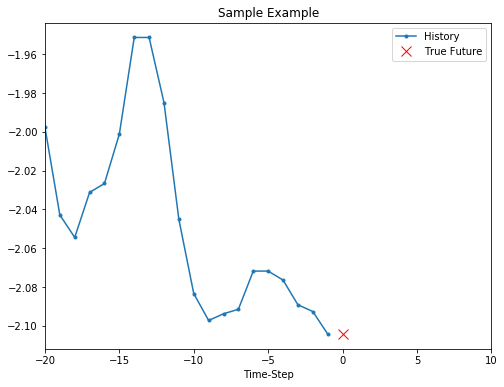

In [19]:
show_plot([x_train_uni[0],y_train_uni[0]],0,'Sample Example')

In [21]:
y_train_uni[0]

-2.1041848598100876

###基准线
在继续训练模型之前，让我们首先设置一个简单的基线。在给定输入点的情况下，基线方法将查看所有历史记录，并预测下一个点是最近20次观察的平均值。

In [0]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

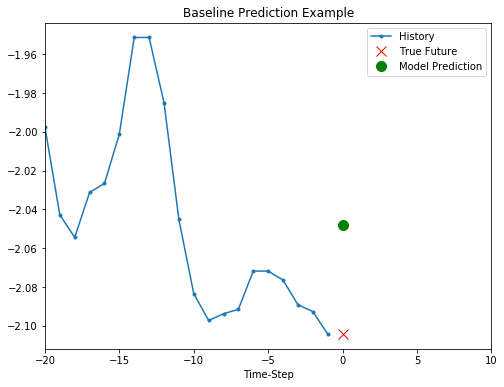

In [46]:
show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])],0,'Baseline Prediction Example')

让我们看看您是否可以使用递归神经网络超越这一基线。

###递归神经网络
递归神经网络（RNN）是一种非常适合时间序列数据的神经网络。RNN分步处理时间序列，并保持内部状态，以汇总到目前为止所看到的信息。有关更多详细信息，请阅读[RNN教程](https://www.tensorflow.org/tutorials/sequences/recurrent?hl=zh_cn)。在本教程中，您将使用一个称为RNN的专用RNN层（[LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM?hl=zh_cn)）

现在`tf.data`，我们使用它来随机整理，批处理和缓存数据集。

In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

以下可视化效果应有助于您理解批处理后数据的表示方式。
![](https://www.tensorflow.org/tutorials/structured_data/images/time_series.png?hl=zh_cn)

您将看到LSTM需要给出的数据的输入形状。

In [24]:
x_train_uni.shape

(299980, 20, 1)

In [26]:
for x,y in val_univariate.take(1):
  print('x.shape:',x.shape)
  print('y.shape:',y.shape)
  print(x)

x.shape: (256, 20, 1)
y.shape: (256,)
tf.Tensor(
[[[0.642228  ]
  [0.63643877]
  [0.63643877]
  ...
  [0.60401906]
  [0.60054552]
  [0.60054552]]

 [[0.63643877]
  [0.63643877]
  [0.63643877]
  ...
  [0.60054552]
  [0.60054552]
  [0.59938767]]

 [[0.63643877]
  [0.63643877]
  [0.63643877]
  ...
  [0.60054552]
  [0.59938767]
  [0.59938767]]

 ...

 [[0.6445437 ]
  [0.6445437 ]
  [0.64801724]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]

 [[0.6445437 ]
  [0.64801724]
  [0.6445437 ]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]

 [[0.64801724]
  [0.6445437 ]
  [0.65149078]
  ...
  [0.65264863]
  [0.65264863]
  [0.65264863]]], shape=(256, 20, 1), dtype=float64)


In [0]:
simple_lstm_model = keras.models.Sequential([
    keras.layers.LSTM(8,input_shape=x_train_uni.shape[-2:]),
    keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam',loss='mae')

让我们进行样本预测，以检查模型的输出。

In [49]:
for x,y in val_univariate.take(1):
  print(simple_lstm_model.predict(x).shape)

(256, 1)


让我们现在训练模型。由于数据集的大小很大，为了节省时间，每个纪元将仅运行200个步骤，而不是像通常那样运行完整的训练数据。

In [0]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

In [51]:
simple_lstm_model.fit(train_univariate,epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
172/200 [========================>.....] - ETA: 0s - loss: 0.0312WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.


In [53]:
simple_lstm_model.layers

###使用简单的LSTM模型进行预测
既然您已经训练了简单的LSTM，让我们尝试做一些预测。

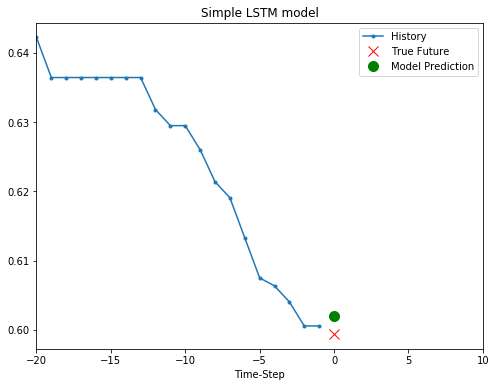

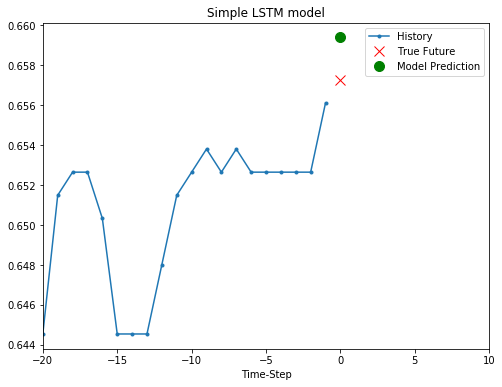

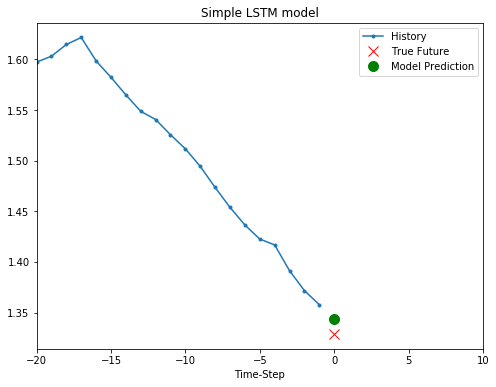

In [56]:
for x,y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(),y[0].numpy(),
                    simple_lstm_model.predict(x)[0]],
                   0,'Simple LSTM model')
  plot.show()

##第2部分：预测多元时间序列
原始数据集包含十四个特征。为简单起见，本节仅考虑原始的十四个中的三个。使用的功能是气温，大气压力和空气密度。

要使用更多功能，请将其名称添加到此列表中。

In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [58]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


让我们看一下这些功能在时间上的变化。

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f157e180240>,
      dtype=object)

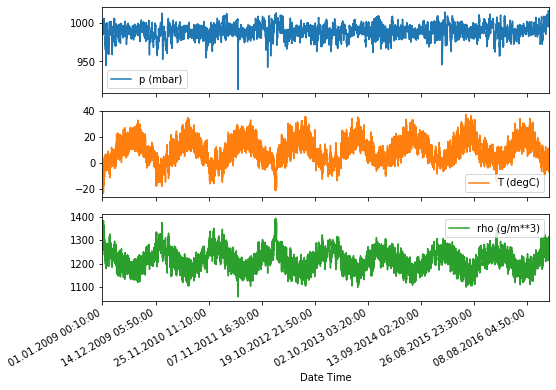

In [59]:
features.plot(subplots=True)

如前所述，第一步将是使用训练数据的均值和标准差对数据集进行标准化。

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [0]:
dataset = (dataset - data_mean)/data_std

###单步模型
在一步设置中，模型将根据提供的某些历史记录来学习预测未来的单个点。

下面的函数执行与下面相同的加窗任务，但是，这里它根据给定的步长对过去的观察进行采样。

In [0]:
def multivariate_data(dataset,target,start_index,end_index,history_size,
                      target_size,step,single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index,end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

在本教程中，将向网络显示最近五（5）天的数据，即每小时采样720个观测值。每隔一小时进行一次采样，因为预计60分钟内不会发生剧烈变化。因此，120次观察代表最近五天的历史。对于单步预测模型，数据点的标签是未来12小时的温度。为了为此创建标签，使用72（12 * 6）次观察后的温度。

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

让我们看一个数据点。

In [64]:
print('历史数据的形状： {}'.format(x_train_single[0].shape))

历史数据的形状： (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

让我们看看样本预测。

In [79]:
for x, y in val_data_single.take(1):
  p = single_step_model.predict(x)
  print('预测形状：',p.shape)
  print('实际值：',y[0])
  print('预测值：',p[0])

预测形状： (256, 1)
实际值： tf.Tensor(1.442300216504111, shape=(), dtype=float64)
预测值： [-0.14361161]


现在没经过学习过程，和预测的相差太远

In [80]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 19ms/step - loss: 0.3155 - val_loss: 0.2621
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2620 - val_loss: 0.2478
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2589 - val_loss: 0.2432
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2542 - val_loss: 0.2403
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2265 - val_loss: 0.2349
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 0.2396 - val_loss: 0.2520
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.2402 - val_loss: 0.2609
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2408 - val_loss: 0.2410
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 0.2407 - val_loss: 0.2416
Epoch 10/10
200/200 [===========================

测试一下看看

In [81]:
for x, y in val_data_single.take(1):
  p = single_step_model.predict(x)
  print('预测形状：',p.shape)
  print('实际值：',y[0])
  print('预测值：',p[0])

预测形状： (256, 1)
实际值： tf.Tensor(1.442300216504111, shape=(), dtype=float64)
预测值： [1.2546225]


显然现在要比原来好多了

In [0]:
def plot_train_history(history,title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs,loss,'b',label='Training loss')
  plt.plot(epochs,val_loss,'r',label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

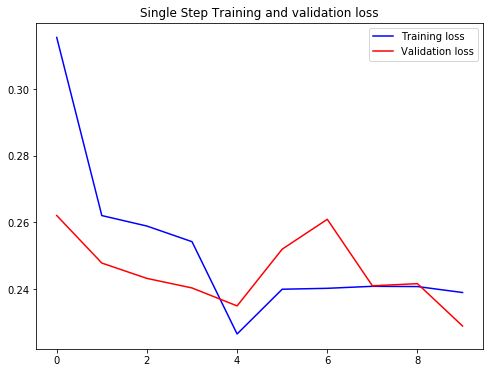

In [85]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

###预测未来的一步
现在已经对模型进行了训练，让我们进行一些样本预测。为模型提供了过去五天内每小时采样的三个特征的历史记录（120个数据点），因为目标是预测温度，所以该图仅显示过去的温度。预测是在未来一天进行的（因此，历史记录和预测之间存在差距）。

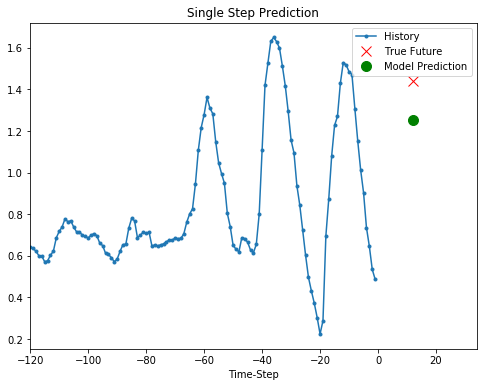

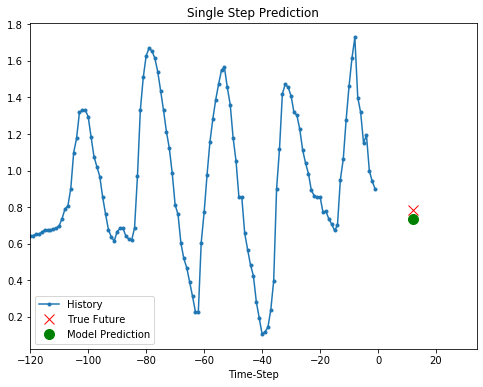

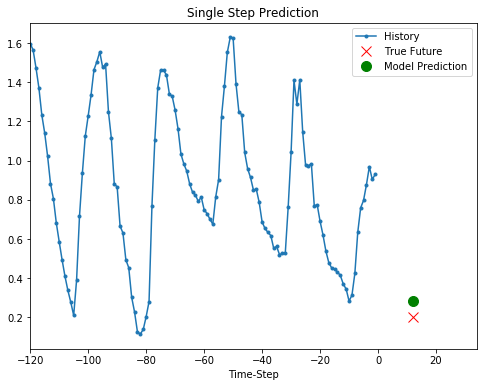

In [86]:
for x,y in val_data_single.take(3):
  plot = show_plot([x[0][:,1].numpy(),y[0].numpy(),
                    single_step_model.predict(x)[0]],12,
                   'Single Step Prediction')
  plot.show()

###多步模型
在多步骤预测模型中，给定过去的历史，该模型需要学习预测一系列未来值。因此，与仅预测单个未来点的单步模型不同，多步模型预测未来的序列。

对于多步骤模型，训练数据再次包括每小时采样的过去五天的记录。但是，这里的模型需要学习预测接下来12小时的温度。由于每10分钟进行一次反驳，因此输出为72个预测。对于此任务，需要相应地准备数据集，因此第一步只是再次创建它，但使用不同的目标窗口。

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

让我们检查一个样本数据点。

In [89]:
print('单个历史记录形状:{}'.format(x_train_multi[0].shape))
print('\n 预测值形状 : {}'.format(y_train_multi[0].shape))

单个历史记录形状:(120, 3)

 预测值形状 : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

绘制样本数据点。

In [0]:
def multi_step_plot(history, true_future,prediction):
  plt.figure(figsize=(12,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in,np.array(history[:,1]),label='History')
  plt.plot(np.arange(num_out)/STEP,np.array(true_future),'bo',label='True Future')

  if prediction.any():
    plt.plot(np.arange(num_out)/STEP,np.array(prediction),'ro',
             label='Predicted Future')
    
  plt.legend(loc='upper left')
  plt.show()

在此图和后续类似图中，每小时都会采样历史记录和将来的数据。

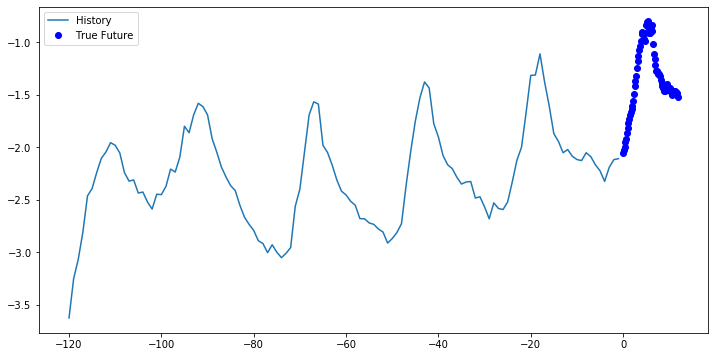

In [92]:
for x,y in train_data_multi.take(1):
  multi_step_plot(x[0],y[0],np.array([0]))

由于此处的任务比先前的任务要复杂一些，因此该模型现在由两个LSTM层组成。最后，由于进行了72个预测，因此密集层将输出72个预测。

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(keras.layers.LSTM(32,
                                       return_sequences=True,
                                       input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(keras.layers.LSTM(16,activation='relu'))
multi_step_model.add(keras.layers.Dense(72))

multi_step_model.compile(optimizer=keras.optimizers.RMSprop(clipvalue=1.0),loss='mae')

让我们看看模型在训练之前如何预测。

In [95]:
for x,y in val_data_multi.take(1):
  p = multi_step_model.predict(x)
  print('预测形状：',p.shape)
  print('实际：', y[0].numpy())
  print('预测：',p[0])

预测形状： (256, 72)
实际： [0.36897613 0.34697704 0.30297886 0.29255824 0.28329546 0.29255824
 0.28213762 0.25319144 0.22771881 0.21845604 0.19414125 0.15361661
 0.13509106 0.13509106 0.12582828 0.11193412 0.10614489 0.10267135
 0.11656551 0.12003905 0.11540766 0.11193412 0.11772335 0.12582828
 0.13161752 0.12814398 0.1385646  0.14319599 0.14203814 0.15477446
 0.158248   0.18603632 0.20340403 0.21614034 0.23813943 0.26361207
 0.27171699 0.27634838 0.28097977 0.32960934 0.39792231 0.43960479
 0.50444422 0.64685939 0.76843332 0.84253552 0.90042786 0.89232294
 0.98147715 1.09610399 1.10652461 1.10420892 1.11694524 1.19683667
 1.2616761  1.32304199 1.37167156 1.43187959 1.42030113 1.4295639
 1.5036661  1.48398271 1.46314146 1.47587778 1.47356208 1.47587778
 1.47124639 1.47819347 1.46082577 1.43882668 1.45503653 1.45851007]
预测： [ 0.03234603 -0.12252881 -0.07958838  0.04928344 -0.05372958 -0.03799371
 -0.0237718   0.09446827  0.00474459 -0.05335713 -0.05992397 -0.00528738
 -0.0171262  -0.13469742 -

In [96]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 27s 135ms/step - loss: 4.0371 - val_loss: 0.3814
Epoch 2/10
200/200 [==============================] - 24s 122ms/step - loss: 0.4222 - val_loss: 0.2980
Epoch 3/10
200/200 [==============================] - 25s 123ms/step - loss: 0.3560 - val_loss: 0.2635
Epoch 4/10
200/200 [==============================] - 24s 122ms/step - loss: 0.2769 - val_loss: 0.2140
Epoch 5/10
200/200 [==============================] - 25s 124ms/step - loss: 0.2143 - val_loss: 0.2017
Epoch 6/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2153 - val_loss: 0.2093
Epoch 7/10
200/200 [==============================] - 25s 123ms/step - loss: 0.2094 - val_loss: 0.2036
Epoch 8/10
200/200 [==============================] - 24s 122ms/step - loss: 0.2040 - val_loss: 0.1925
Epoch 9/10
200/200 [==============================] - 24s 121ms/step - loss: 49.4046 - val_loss: 0.2273
Epoch 10/10
200/200 [========

###预测多步骤的未来
现在让我们看一下您的网络在预测未来方面的学习情况。

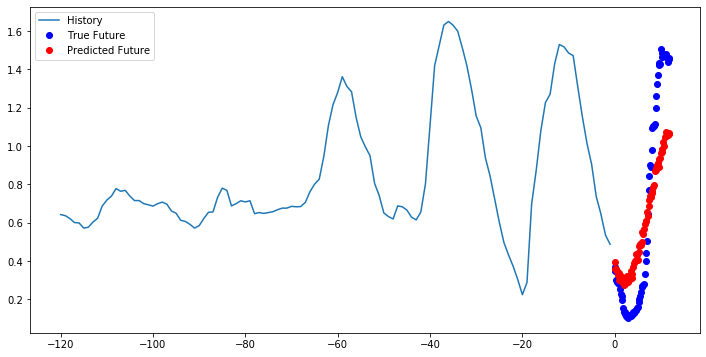

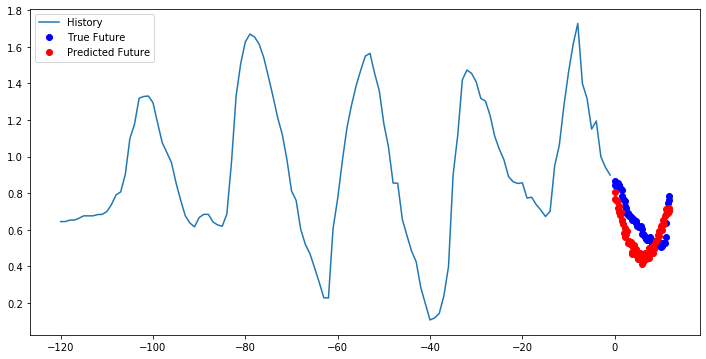

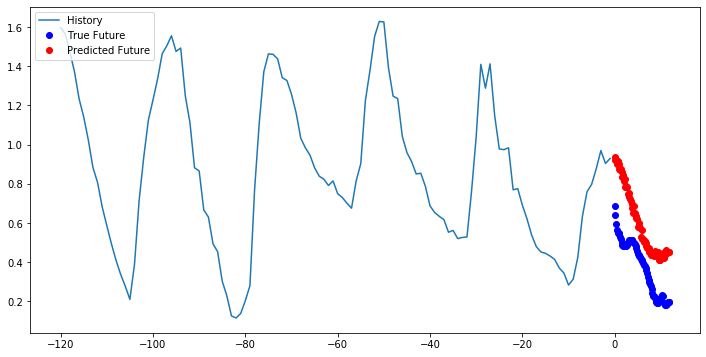

In [97]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

###下一步
本教程是使用RNN进行时间序列预测的快速介绍。您现在可以尝试预测股票市场并成为亿万富翁。

此外，您还可以编写一个生成器来生成数据（而不是uni / multivariate_data函数），这将提高内存效率。您也可以查看此时间序列窗口指南，并在本教程中使用它。

为了进一步理解，您可以阅读《使用Scikit-Learn，Keras和TensorFlow进行动手机器学习》（第2版）的第15章和《使用Python进行深度学习》的第6章。